In [2]:
import pandas as pd                                    # Working with tables
import numpy as np


from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'349dd4117e5d1ed71a22f0207a8e439cf3f7b06b'})
quandl.ApiConfig.api_key = '_ci7hzC_sPkspKWz2yzt'                      # Replace the XXXX with your API key (must be inside the ' ').

import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice.
%matplotlib inline

# YTD

In [3]:
tickers    = ['ASX','AGG']
start_ytd  = '1-1-2022'
end_ytd    = '3-23-2022'

Now let's look at the returns

In [27]:

prices  = tiingo.get_dataframe(tickers, start_ytd, end_ytd, metric_name='adjClose')
prices.index = pd.to_datetime(prices.index).tz_convert(None) 
r = prices.pct_change()
    
r.count()


ASX    54
AGG    54
dtype: int64

In [28]:
rf = 0.011
risk_premiums = r.mean() * 54 - rf  
risk_premiums

ASX   -0.041261
AGG   -0.067165
dtype: float64

In [29]:
vol           = r.std()  * 54**0.5
vol

ASX    0.190157
AGG    0.030592
dtype: float64

In [30]:
corr          = r.corr()
corr

,ASX,AGG
ASX,1.000000,-0.086389
AGG,-0.086389,1.000000


In [31]:
cov           = r.cov()  * 54
cov

,ASX,AGG
ASX,0.036160,-0.000503
AGG,-0.000503,0.000936


Now we can make a mean-volatility plot to see where these two stocks stand.

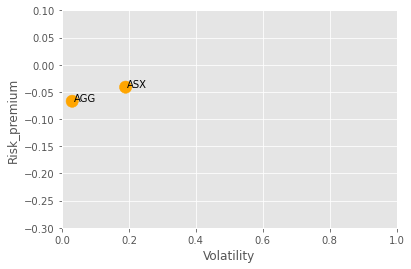

In [32]:
assets = pd.DataFrame()                        
assets['Risk_premium'] = risk_premiums
assets['Volatility']   = vol    
assets['Color']        = 'orange'
assets['Size']         = 150

all_portfolios = assets
all_portfolios
    
graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,1), ylim=(-0.3,0.1))

    # add ticker symbols to plot:
for s in tickers:                                 # loop over sectors
    x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
    graph.text(x,y,s)                             # add the ticker symbol to the graph

We can also make an efficient frontier plot to see how different weighted combinations of these stocks would land on the mean-volatility plot.

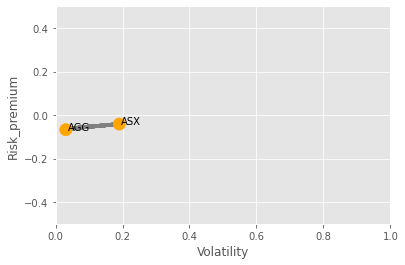

In [33]:
   
# here we are building the simulation that finds the possible portfolios
n_portfolios = 1000

random_arrays  = [ np.random.uniform(0,1,len(tickers)) for i in range(0,n_portfolios) ]
random_weights = [ ra/ra.sum() for ra in random_arrays ]
    
random = pd.DataFrame()
random['Risk_premium'] = [ w.dot(risk_premiums)   for w in random_weights ]
random['Volatility']   = [ w.dot(cov).dot(w)**0.5 for w in random_weights ]
random['Color']        = 'gray'
random['Size']         = 10
random['sharpe']       = random['Risk_premium']/random['Volatility']

all_portfolios = pd.concat([random, assets])
    
graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,1), ylim=(-0.5,0.5))

# add ticker to plot:
for s in tickers:                                 # loop over sectors
    x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
    graph.text(x,y,s)                             # add the ticker symbol to the graph


Time to find the weights that correspond to the maximum sharpe ratio portfolio.

In [34]:

random['weights'] = random_weights
wgts = random[(random['sharpe'] >= random.sharpe.max())].weights.astype(str)

rp = random[(random['sharpe'] == random.sharpe.max())].Risk_premium
#now I have found the weights, but they are in string form. We want them to be a panda series
#here i am turning the string weights into a list
lw = list(wgts)
#finding the first entry in the list(the first entry is always a quote)
ws = str(lw[0])
# replacing the quote with a blank
ws = ws.replace('[','')
ws = ws.replace(']','')
#deliniating the list values by spaces
lw = ws.split(' ')
#filtering out the bad data
lw = list(filter(None, lw))
#Finally turning the list into a numpy array
nw = np.array(lw)
nw = nw.astype(float)
    
#now we have to turn the numpy array into a panda series 
    
sharpe_weights                  = pd.DataFrame()
sharpe_weights['Risk_Premiums'] = risk_premiums
sharpe_weights['Weights']       = nw
sharpe_weights['weighted_ret']  = sharpe_weights['Weights']*sharpe_weights['Risk_Premiums']
sharpe_weights

,Risk_Premiums,Weights,weighted_ret
ASX,-0.041261,0.997658,-0.041165
AGG,-0.067165,0.002342,-0.000157


In [35]:
rf = 0.011
r*sharpe_weights['Weights']
r['total_ret'] = r.ASX + r.AGG
r

,ASX,AGG,total_ret
2022-01-03,NaN,NaN,NaN
2022-01-04,0.001271,-0.000088,0.001182
2022-01-05,0.005076,-0.003089,0.001987
2022-01-06,0.008838,-0.001063,0.007776
2022-01-07,-0.043805,-0.002925,-0.046730
2022-01-10,0.026178,-0.000889,0.025289
2022-01-11,0.008929,0.001868,0.010797
2022-01-12,-0.007585,0.000000,-0.007585
2022-01-13,-0.003822,0.001776,-0.002045
2022-01-14,0.014066,-0.005585,0.008481


In [37]:
max_rp = r.total_ret.mean()*54 - 0.011
max_rp

-0.09742633594116

In [38]:
max_vol = r.total_ret.std()*54**0.05
max_vol

0.03155868643682369

In [39]:
max_sharpe = max_rp/max_vol
max_sharpe

-3.0871480071325093